# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

In [2]:
# Load data
data_ii = pd.read_csv('best_ball_mania_ii.csv')
data_iii = pd.read_csv('best_ball_mania_iii.csv')
data_iv = pd.read_csv('best_ball_mania_iv.csv')

In [3]:
# Increase 'roster_points' and 'pick_points' for dataset iv by 4.5
data_iv['pick_points'] = data_iv['pick_points']*4.5
data_iv['roster_points'] = data_iv['roster_points']*4.5

# Columns that are in all datasets
cols = list(set(data_ii.columns) & set(data_iii.columns) & set(data_iv.columns))

# Filter columns
data_ii = data_ii[cols]
data_iii = data_iii[cols]
data_iv = data_iv[cols]

# Concatenate data
data = pd.concat([data_ii, data_iii, data_iv], axis=0)

In [4]:
# Rename 'tournament_entry_id' to 'team_id'
data = data.rename(columns={'tournament_entry_id': 'team_id'})

data = data.drop(columns=['clock', 'tournament_round_number', 'bye_week', 'draft_time'])

# Fit a polynomial regression
p = np.poly1d(np.polyfit(data['overall_pick_number'], data['pick_points'], 2))
data['poly_points'] = p(data['overall_pick_number'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648000 entries, 0 to 215999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_name          648000 non-null  object 
 1   draft_id             648000 non-null  object 
 2   pick_points          648000 non-null  float64
 3   overall_pick_number  648000 non-null  int64  
 4   position_name        648000 non-null  object 
 5   playoff_team         648000 non-null  int64  
 6   team_pick_number     648000 non-null  int64  
 7   roster_points        648000 non-null  float64
 8   team_id              648000 non-null  object 
 9   pick_order           648000 non-null  int64  
 10  projection_adp       648000 non-null  float64
 11  poly_points          648000 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 64.3+ MB


## Data Preprocessing for Models

make a df that has the selected ranking for each position. the team that selected the 7th WR has their first WR1 as "7."

make a df that has the average adp for each position. a team selects their WR1 and that individual had an adp of "2.3"

### Add a column in the cleaning notebook that identifies teams that happened to pick a player that scored an unexpected amount of points. Teams that picked the best player of that year should be flagged and teams that picked a top player that did absolutely nothing should also be flagged. This will be used to compare teams that are similar in terms of luck, two teams who happened to pick great players should be compared based on their position compositions

In [7]:
# Transform data into the selection at which each team drafted each position
def ordinal_ranks(data, drop_columns=False, empty_value=1000):
    # Group by 'draft_id', 'position_name', 'pick_points' and 'overall_pick_number'
    df = data[['team_id', 'position_name', 'overall_pick_number', 'pick_points']]
    roster_points = data[['team_id', 'roster_points']].drop_duplicates()

    data_grouped = df.groupby(['team_id', 'position_name', 'overall_pick_number']).mean().reset_index()
    data_grouped = data_grouped[['team_id', 'position_name', 'overall_pick_number']]
    data_grouped = data_grouped.drop(data_grouped[data_grouped['position_name'] == 'FB'].index)

    # New column 'pos_rank' which is the rank of the 'position_name' in each 'draft_id'
    # if lowest 'overall_pick_number' then rank is 1, if second lowest then rank is 2, and so on
    data_grouped['pos_rank'] = data_grouped.groupby(['team_id', 'position_name'])['overall_pick_number'].rank()

    # New column pos_team_rank which is position_name + pos_rank
    data_grouped['pos_team_rank'] = data_grouped['position_name'] + data_grouped['pos_rank'].astype(str)

    # Pivot the data so that position names are columns, and overall pick numbers are rows
    data_grouped = data_grouped.pivot(index='team_id', columns='pos_team_rank', values='overall_pick_number').reset_index()

    # Drop columns below 5 percent full
    if drop_columns == True:
        data_grouped = data_grouped.dropna(thresh=0.30*len(data_grouped), axis=1)

    # Fill NaN values with empty_value
    data_grouped = data_grouped.fillna(empty_value)

    # Merge with 'roster_points'
    data_grouped = data_grouped.merge(roster_points, on='team_id')
    
    # Drop 'team_id' column
    data_grouped = data_grouped.drop(columns=['team_id'])

    return data_grouped

ordinal_ranks(data, drop_columns=False).head()

,QB1.0,QB2.0,QB3.0,QB4.0,QB5.0,QB6.0,QB7.0,QB8.0,RB1.0,RB10.0,...,WR12.0,WR2.0,WR3.0,WR4.0,WR5.0,WR6.0,WR7.0,WR8.0,WR9.0,roster_points
0,36.0,156.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,13.0,1000.0,...,1000.0,60.0,61.0,84.0,85.0,133.0,181.0,204.0,1000.0,1622.50
1,47.0,194.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,26.0,1000.0,...,1000.0,23.0,50.0,119.0,122.0,143.0,167.0,191.0,215.0,1177.38
2,68.0,188.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,1000.0,...,1000.0,44.0,53.0,77.0,92.0,116.0,164.0,173.0,212.0,1487.10
3,115.0,126.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,6.0,1000.0,...,1000.0,30.0,67.0,78.0,91.0,102.0,163.0,187.0,211.0,1633.24
4,31.0,151.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,7.0,1000.0,...,1000.0,66.0,79.0,103.0,127.0,186.0,210.0,1000.0,1000.0,1752.82


In [8]:
# Transform data into the "value" of the selection at which each team drafted each position
def value_ranks(data, drop_columns):
    # Introduce data: the selection at which each position was drafted
    empty_value = 1000
    df = ordinal_ranks(data, drop_columns, empty_value)

    # Fit a polynomial regression
    p = np.poly1d(np.polyfit(data['overall_pick_number'], data['pick_points'], 2))

    # Use the polynomial regression to find the value of each selection, except for column: 'roster_points'
    roster_points = df['roster_points']
    df = df.drop(columns=['roster_points'])
    df = df.map(lambda x: p(x))

    # Replace all null values with 0
    df = df.replace(p(empty_value), 0)
    df = df.round(2)
    
    # Add roster_points back to the dataframe
    df['roster_points'] = roster_points

    return df

value_ranks(data, drop_columns=True).head()

,QB1.0,QB2.0,QB3.0,RB1.0,RB2.0,RB3.0,RB4.0,RB5.0,RB6.0,TE1.0,...,TE3.0,WR1.0,WR2.0,WR3.0,WR4.0,WR5.0,WR6.0,WR7.0,WR8.0,roster_points
0,130.66,51.84,0.0,153.16,75.59,74.99,51.46,43.85,38.29,129.73,...,0.0,154.20,109.71,108.89,91.36,90.65,61.93,43.58,38.46,1622.50
1,120.74,40.39,0.0,140.15,98.69,83.81,81.85,55.94,0.00,100.98,...,0.0,164.77,143.09,118.12,69.23,67.59,57.25,47.86,41.06,1177.38
2,103.31,41.77,0.0,161.55,146.06,66.00,58.61,54.66,0.00,79.92,...,0.0,137.26,123.39,115.55,96.44,85.81,70.91,48.89,45.92,1487.10
3,71.48,65.47,0.0,160.49,124.28,59.07,54.24,39.56,0.00,114.70,...,0.0,147.06,136.30,104.09,95.70,86.49,79.29,49.24,42.01,1633.24
4,135.35,53.83,0.0,159.43,113.86,87.17,72.06,59.53,45.30,148.07,...,0.0,125.18,104.88,94.97,78.66,64.95,42.26,37.51,0.00,1752.82


## Feature Engineering

In [9]:
# Get data
df = value_ranks(data, drop_columns=False)

# Add position counts
df['qb_count'] = df.filter(like='QB').gt(0).sum(axis=1)
df['rb_count'] = df.filter(like='RB').gt(0).sum(axis=1)
df['wr_count'] = df.filter(like='WR').gt(0).sum(axis=1)
df['te_count'] = df.filter(like='TE').gt(0).sum(axis=1)

# Add position value allocation
df['qb_value'] = df.filter(like='QB').sum(axis=1)
df['rb_value'] = df.filter(like='RB').sum(axis=1)
df['wr_value'] = df.filter(like='WR').sum(axis=1)
df['te_value'] = df.filter(like='TE').sum(axis=1)

# Add position variance in value
df['qb_var'] = df.filter(like='QB').var(axis=1).round(2)
df['rb_var'] = df.filter(like='RB').var(axis=1).round(2)
df['wr_var'] = df.filter(like='WR').var(axis=1).round(2)
df['te_var'] = df.filter(like='TE').var(axis=1).round(2)

# Add high draft pick count
df['qb_early'] = df.filter(like='QB').gt(120).sum(axis=1)
df['rb_early'] = df.filter(like='RB').gt(120).sum(axis=1)
df['wr_early'] = df.filter(like='WR').gt(120).sum(axis=1)
df['te_early'] = df.filter(like='TE').gt(120).sum(axis=1)

# Add top vs. bottom value difference 
df['qb_diff'] = df.filter(like='QB').max(axis=1) - df.filter(like='QB').min(axis=1)
df['rb_diff'] = df.filter(like='RB').max(axis=1) - df.filter(like='RB').min(axis=1)
df['wr_diff'] = df.filter(like='WR').max(axis=1) - df.filter(like='WR').min(axis=1)
df['te_diff'] = df.filter(like='TE').max(axis=1) - df.filter(like='TE').min(axis=1)

# Add interaction terms
df['qb_rb'] = (df['qb_value'] * df['rb_value']).round(0)
df['qb_wr'] = (df['qb_value'] * df['wr_value']).round(0)
df['qb_te'] = (df['qb_value'] * df['te_value']).round(0)
df['rb_wr'] = (df['rb_value'] * df['wr_value']).round(0)
df['rb_te'] = (df['rb_value'] * df['te_value']).round(0)
df['wr_te'] = (df['wr_value'] * df['te_value']).round(0)

# Keep columns
columns_to_keep = ['QB1.0', 'QB2.0', 'RB1.0', 'RB2.0', 'RB3.0', 'RB4.0', 'TE1.0', 'TE2.0',
       'WR1.0', 'WR2.0', 'WR3.0', 'WR4.0', 'WR5.0', 'WR6.0', 'roster_points',
       'qb_count', 'rb_count', 'wr_count', 'te_count', 'qb_value', 'rb_value',
       'wr_value', 'te_value', 'qb_var', 'rb_var', 'wr_var', 'te_var',
       'qb_early', 'rb_early', 'wr_early', 'te_early', 'qb_diff', 'rb_diff',
       'wr_diff', 'te_diff', 'qb_rb', 'qb_wr', 'qb_te', 'rb_wr', 'rb_te',
       'wr_te']
df = df[columns_to_keep]

df.corr()['roster_points'].sort_values(ascending=False)

roster_points    1.000000
wr_early         0.086270
WR3.0            0.074923
WR4.0            0.067989
wr_var           0.063756
WR2.0            0.058170
wr_value         0.054262
WR5.0            0.044782
WR1.0            0.040354
wr_diff          0.040350
rb_wr            0.037591
WR6.0            0.026352
rb_count         0.014117
wr_te            0.009239
wr_count         0.008618
te_count         0.004213
RB4.0           -0.002997
qb_diff         -0.002998
QB1.0           -0.003073
qb_wr           -0.005599
te_diff         -0.014455
TE1.0           -0.014508
te_var          -0.017237
qb_var          -0.017282
te_early        -0.018828
RB1.0           -0.021553
rb_diff         -0.021649
te_value        -0.023600
TE2.0           -0.024362
rb_value        -0.025148
qb_early        -0.029094
QB2.0           -0.029961
rb_te           -0.032142
RB3.0           -0.040115
qb_count        -0.040546
rb_var          -0.041338
RB2.0           -0.044119
qb_value        -0.045325
qb_te       

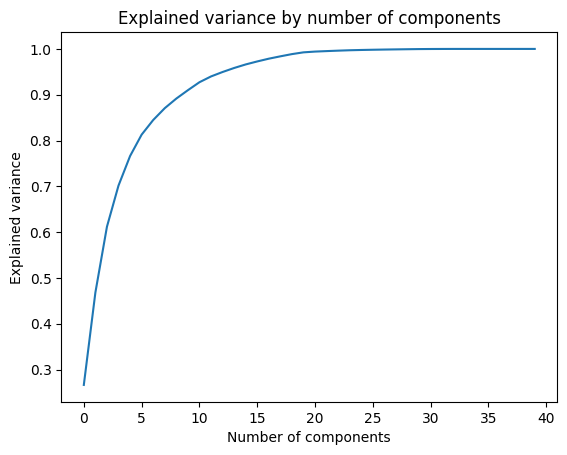

In [19]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
X = df.drop(columns=['roster_points'])
y = df['roster_points']
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance by number of components')
plt.show()

# Save pca with 85% explained variance
pca = PCA(n_components=0.95)
pca.fit(X_scaled)
df_pca = pca.transform(X_scaled)
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

In [20]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,0.228070,-2.944915,1.143337,1.391703,2.113139,0.457014,1.201325,0.630943,-1.539670,0.289682,-0.454289,1.167857,-0.758177,-0.358267
1,1.907469,-0.240870,-0.641261,0.468075,2.146510,1.077243,-1.949928,0.546511,-1.129072,0.203508,1.223688,0.228417,-0.066023,0.982474
2,1.315389,3.446763,0.481296,2.443804,0.808311,0.198516,0.772380,0.379691,-0.024587,0.262790,0.236113,-0.861611,0.222322,-0.395876
3,1.950119,1.795549,2.581268,1.651074,-0.157964,-0.375191,0.178362,1.205501,0.158189,-0.436544,-0.911194,0.031095,0.427777,0.903637
4,-4.232282,-1.915476,0.830311,-0.218332,3.550821,-0.267807,2.210408,0.023067,-0.057083,-0.132021,0.822509,0.042506,-0.513275,0.170332


In [21]:
# correlation between df_pca and 'roster_points'
df_pca['roster_points'] = y
df_pca.corr()['roster_points']

roster_points    1.000000
PC1              0.070945
PC11             0.048354
PC7              0.021385
PC6              0.019144
PC8              0.017830
PC5              0.017063
PC9              0.011053
PC2              0.004937
PC3              0.004443
PC13             0.002816
PC12            -0.007431
PC4             -0.019801
PC10            -0.019828
PC14            -0.027117
Name: roster_points, dtype: float64

## Modeling

In [40]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define X and y
X = df_pca.drop(columns='roster_points')
y = df_pca['roster_points']

# Fit an XGBoost regressor
xgbr = xgb.XGBRegressor(n_estimators=100, # Number of boosted trees to fit
                        learning_rate=0.01, # Boosting learning rate
                        colsample_bytree=1, # Subsample ratio of columns when constructing each tree
                        gamma=10, # Minimum loss reduction required to make a further partition on a leaf node of the tree
                        max_depth=20, # Maximum tree depth for base learners
                        subsample=0.5 # Subsample ratio of the training instance when constructing each tree
                        )

# Implement k-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True)
scores = cross_val_score(xgbr, X, y, cv=kfold)

# Print the mean and standard deviation of the scores
print(f"Cross-validation R^2 score: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Cross-validation R^2 score: 0.01 (+/- 0.00)


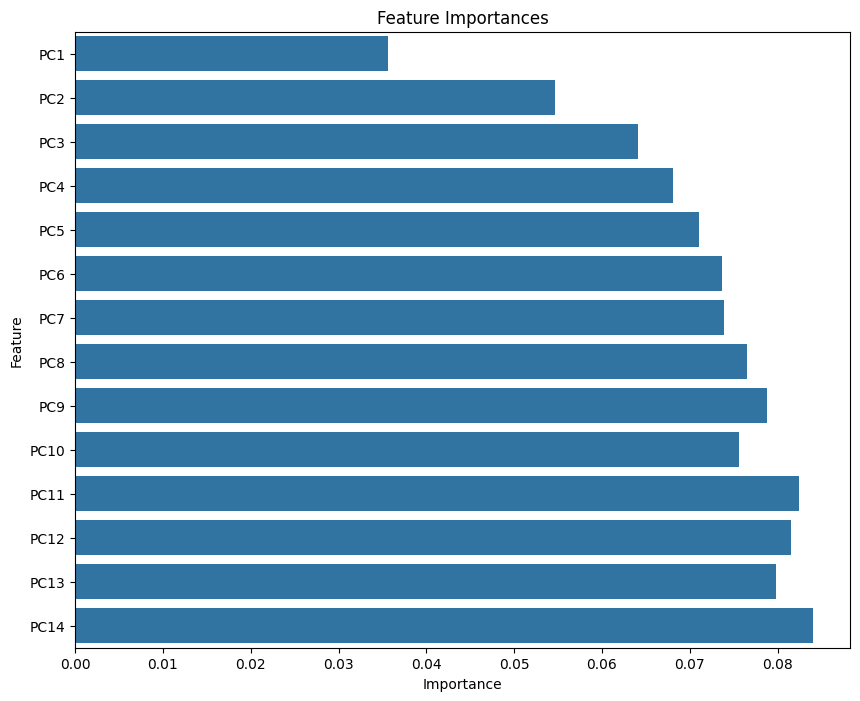

In [24]:
# Feature importance
xgbr.fit(X, y)

# Get feature importances
importances = xgbr.feature_importances_

plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Time Series Analysis with Cumulative Sums

In [38]:
# Define data
df = data[['pick_points', 'team_pick_number', 'poly_points', 'position_name', 'team_id', 'roster_points']].copy()

# Sort by 'team_id' and 'overall_pick_number'
df = df.sort_values(['team_id', 'team_pick_number'])

# Transpose position_name and poly_points
df['WR'] = df['position_name'].apply(lambda x: 1 if x == 'WR' else 0)
df['WR'] = df['poly_points'] * df['WR']
df['RB'] = df['position_name'].apply(lambda x: 1 if x == 'RB' else 0)
df['RB'] = df['poly_points'] * df['RB']
df['QB'] = df['position_name'].apply(lambda x: 1 if x == 'QB' else 0)
df['QB'] = df['poly_points'] * df['QB']
df['TE'] = df['position_name'].apply(lambda x: 1 if x == 'TE' else 0)
df['TE'] = df['poly_points'] * df['TE']

# Cumulative sum of 'WR', 'RB', 'QB', 'TE'
df['WR_cumsum'] = df.groupby('team_id')['WR'].cumsum()
df['RB_cumsum'] = df.groupby('team_id')['RB'].cumsum()
df['QB_cumsum'] = df.groupby('team_id')['QB'].cumsum()
df['TE_cumsum'] = df.groupby('team_id')['TE'].cumsum()

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define X and y
X = df[['WR_cumsum', 'RB_cumsum', 'QB_cumsum', 'TE_cumsum', 'team_pick_number']]
y = df['roster_points']

# Fit an XGBoost regressor
xgbr = xgb.XGBRegressor(n_estimators=100, # Number of boosted trees to fit
                        learning_rate=0.05, # Boosting learning rate
                        colsample_bytree=1, # Subsample ratio of columns when constructing each tree
                        gamma=10, # Minimum loss reduction required to make a further partition on a leaf node of the tree
                        max_depth=20, # Maximum tree depth for base learners
                        subsample=0.75 # Subsample ratio of the training instance when constructing each tree
                        )

# Implement k-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True)
scores = cross_val_score(xgbr, X, y, cv=kfold)

# Print the mean and standard deviation of the scores
print(f"Cross-validation R^2 score: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Cross-validation R^2 score: 0.08 (+/- 0.00)


# Position Ranking

In [59]:
# Define data
df = data.copy()

# Sort by draft_id and overall_pick_number
df = df.sort_values(['draft_id', 'overall_pick_number'])

# Groupby draft_id and position_name
df['player_rank'] = df.groupby(['draft_id', 'position_name'])['overall_pick_number'].rank()

# Groupby team_id and position_name
df['pos_rank'] = df.groupby(['team_id', 'position_name'])['overall_pick_number'].rank()
df['pos_rank'] = df['pos_rank'].astype(int)
df['pos_rank'] = df['position_name'] + df['pos_rank'].astype(str)

# Pivot the data so that position names are columns, and overall pick numbers are rows
df = df.pivot_table(index=['draft_id', 'team_id', 'roster_points'], columns='pos_rank', values='player_rank').reset_index()

# Define X and y
X = df.drop(columns=['draft_id', 'team_id', 'roster_points'])
y = df['roster_points']

# Fit an XGBoost regressor
xgbr = xgb.XGBRegressor(n_estimators=100, # Number of boosted trees to fit
                        learning_rate=0.05, # Boosting learning rate
                        colsample_bytree=1, # Subsample ratio of columns when constructing each tree
                        gamma=10, # Minimum loss reduction required to make a further partition on a leaf node of the tree
                        max_depth=10, # Maximum tree depth for base learners
                        subsample=0.75 # Subsample ratio of the training instance when constructing each tree
                        )

# Implement k-fold cross-validation
kfold = KFold(n_splits=2, shuffle=True)
scores = cross_val_score(xgbr, X, y, cv=kfold)

# Print the mean and standard deviation of the scores
print(f"Cross-validation R^2 score: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Cross-validation R^2 score: 0.04 (+/- 0.00)
